# COVID-19: Dati della Protezione Civile
Il repo è [COVID-19](https://github.com/pcm-dpc/COVID-19).

In [80]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import git

plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(12,6)

import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [81]:
g = git.cmd.Git("protezione_civile")
g.pull()

'Already up to date.'

In [82]:
dati = pd.read_csv("protezione_civile/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv",index_col="data")
dati.index = pd.to_datetime(dati.index)
dati.drop(columns="stato",inplace=True)

In [83]:
dati.tail()

,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
data,,,,,,,,,,
2020-03-17 17:00:00,12894,2060,14954,11108,26062,2989,2941,2503,31506,148657
2020-03-18 17:00:00,14363,2257,16620,12090,28710,2648,4025,2978,35713,165541
2020-03-19 17:00:00,15757,2498,18255,14935,33190,4480,4440,3405,41035,182777
2020-03-20 17:00:00,16020,2655,18675,19185,37860,4670,5129,4032,47021,206886
2020-03-21 17:00:00,17708,2857,20565,22116,42681,4821,6072,4825,53578,233222


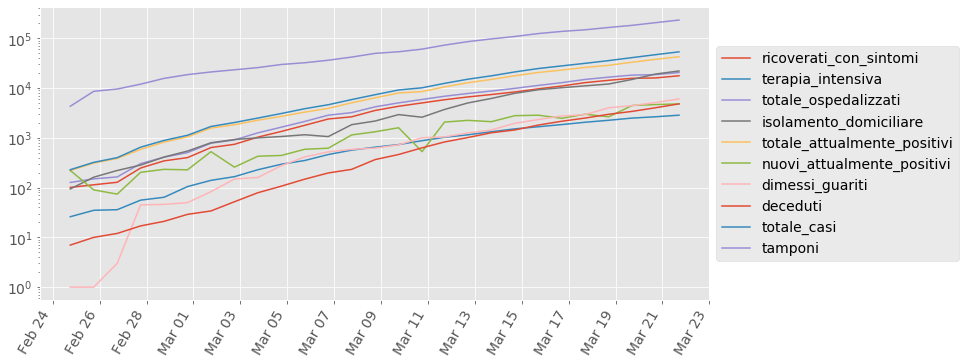

In [68]:
ax = dati.plot(rot=60, logy=True)

ax.set_xlabel('')

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Decessi

In [69]:
# decessi = dati['totale_attualmente_positivi'].resample('1D').sum()
decessi = dati['deceduti'].resample('1D').sum()
giorni_trascorsi = (decessi.index-decessi.index[0]).days
err = np.sqrt(decessi+1)

In [70]:
def logistica(x,a,b,x0): return a/(1+np.exp(-b*(x-x0)))

def rate_logistica(x,a,b,x0): return b/(1+np.exp(b*(x-x0)))

def gompertz(x,a,b,x0): return a*np.exp(-np.exp(-b*(x-x0)))

def rate_gompertz(x,a,b,x0): return b*np.exp(-b*(x-x0))

def esponenziale(x,b,x0): return np.exp((x-x0)/b)

def rate_esponenziale(x,b,x0): return 1./b
rate_esponenziale = np.vectorize(rate_esponenziale)

In [71]:
def logder(data):
    return (data.shift(-1) - data.shift(1))/(2*data)

def errprop(data):
    return ( np.sqrt(data.shift() + data.shift(-1))/(data.shift(-1)-data.shift(1)) + np.sqrt(data)/data)*logder(data)

In [72]:
p0 = [1e3,1,2]
lopt,lcov = curve_fit(logistica,
                      giorni_trascorsi,
                      decessi,
                      p0=p0,sigma=err)

p0 = [1,1]
eopt,ecov = curve_fit(esponenziale,
                      giorni_trascorsi,
                      decessi,
                      p0=p0,sigma=err)

p0 = [1e5,1,1]
gopt,gcov = curve_fit(gompertz,
                      giorni_trascorsi,
                      decessi,
                      p0=p0,sigma=err)

print("Modello logistico:")
print("Numero totale decessi stimato: {}".format(int(lopt[0])))
print("Tempo tipico di crescita: {:.2} giorni".format(1/lopt[1]))
inflection_date = decessi.index[0] + pd.to_timedelta(lopt[2],unit='D')
print("Data di flessione: "+inflection_date.strftime("%F"))
print()    
print("Modello Gompertz:")
print("Numero totale decessi stimato: {}".format(int(gopt[0])))
print("Tempo tipico di crescita: {:.2} giorni".format(1/gopt[1]))
inflection_date = decessi.index[0] + pd.to_timedelta(gopt[2],unit='D')
print("Data di flessione: "+inflection_date.strftime("%F"))

Modello logistico:
Numero totale decessi stimato: 6756
Tempo tipico di crescita: 3.6 giorni
Data di flessione: 2020-03-18

Modello Gompertz:
Numero totale decessi stimato: 71536
Tempo tipico di crescita: 2e+01 giorni
Data di flessione: 2020-04-09


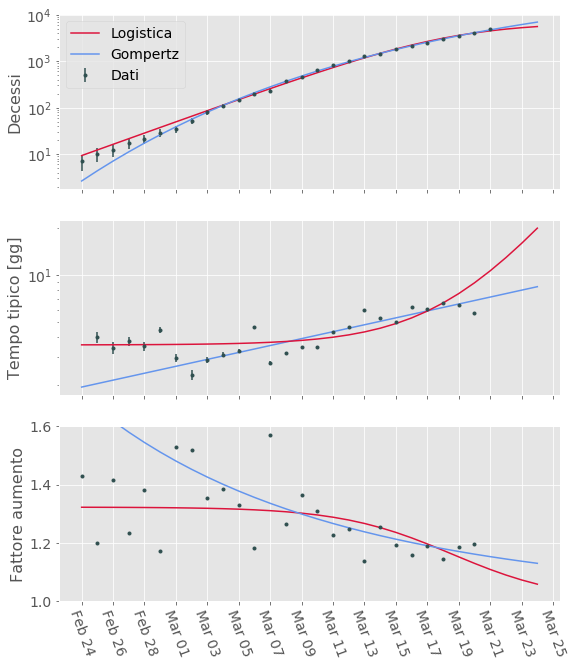

In [73]:
date_proiezione = pd.date_range(decessi.index[0],'2020-03-24')


fig,ax = plt.subplots(3,1,sharex=True, gridspec_kw={'height_ratios': [1,1,1]},figsize=(8,9))
# fig,ax = plt.subplots(2,2,sharex=True,figsize=(16,8))

ax = ax.flatten()

fig.tight_layout()

ax[0].errorbar(decessi.index,decessi,
            yerr=np.sqrt(decessi), 
            fmt=".", 
            color="darkslategray", 
            label="Dati")

ax[0].plot(date_proiezione,logistica((date_proiezione-decessi.index[0]).days, *lopt),label="Logistica",color='crimson')
ax[0].plot(date_proiezione,gompertz((date_proiezione-decessi.index[0]).days, *gopt),label="Gompertz",color="cornflowerblue")
# # ax[0].plot(date_proiezione,esponenziale((date_proiezione-decessi.index[0]).days, *eopt),label="Esponenziale",color='seagreen')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('')
# ax[0].set_ylabel('Positivi')
ax[0].set_ylabel('Decessi')

ax[1].plot(date_proiezione,1/rate_gompertz((date_proiezione-decessi.index[0]).days, *gopt),label="Gompertz",color='cornflowerblue')
ax[1].plot(date_proiezione,1/rate_logistica((date_proiezione-decessi.index[0]).days, *lopt),label="Logistica",color='crimson')
ax[1].errorbar(x=decessi.index,y=1/logder(decessi),yerr=errprop(decessi),fmt='.',color='darkslategray')
ax[1].set_yscale('log')
# ax[1].plot(date_proiezione,rate_esponenziale((date_proiezione-decessi.index[0]).days, *eopt),label="Esponenziale",color='seagreen')
# ax[1].legend()

ax[1].set_xlabel('')
# ax[1].set_ylim(bottom=0,top=0.5)
ax[1].set_ylabel('Tempo tipico [gg]')

ax[2].plot(date_proiezione,logistica((date_proiezione-decessi.index[0]).days, *lopt)/logistica((date_proiezione.shift(-1)-decessi.index[0]).days, *lopt),label="Logistica",color='crimson')
ax[2].plot(date_proiezione,gompertz((date_proiezione-decessi.index[0]).days, *gopt)/gompertz((date_proiezione.shift(-1)-decessi.index[0]).days, *gopt),label="Gompertz",color='cornflowerblue')
ax[2].plot(decessi.index,decessi.shift(-1)/decessi,'.',color='darkslategray')
ax[2].set_ylim(bottom=1,top=1.6)
ax[2].set_ylabel("Fattore aumento")
ax[2].tick_params(axis='x', rotation=-70)
ax[2].xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# ax[2].plot(decessi.index,np.abs(logistica((decessi.index-decessi.index[0]).days, *lopt) - decessi)/np.sqrt(decessi),label="Logistica",color='crimson')
# ax[2].plot(decessi.index,np.abs(gompertz((decessi.index-decessi.index[0]).days, *gopt) - decessi)/np.sqrt(decessi),label="Gompertz",color="cornflowerblue")
# ax[2].set_ylabel("Residui")
# ax[2].set_ylim(bottom=0)
# ax[2].tick_params(axis='x', rotation=-70)

In [74]:
pro = pd.DataFrame(index=date_proiezione)
    
pro["meno peggio"] = logistica((date_proiezione-decessi.index[0]).days, *lopt).astype(int)
pro["male"] = gompertz((date_proiezione-decessi.index[0]).days, *gopt).astype(int)
pro["dati"] = decessi.astype("Int64")

pro

,meno peggio,male,dati
2020-02-24,9,2,7
2020-02-25,12,4,10
2020-02-26,16,7,12
2020-02-27,21,11,17
2020-02-28,28,17,21
2020-02-29,37,26,29
2020-03-01,49,38,34
2020-03-02,65,55,52
2020-03-03,85,79,79
2020-03-04,112,111,107


# Regioni

In [85]:
regioni = pd.read_csv("protezione_civile/dati-regioni/dpc-covid19-ita-regioni.csv")

lombardia = regioni[regioni['denominazione_regione'] == "Lombardia"]
lombardia = lombardia.drop(columns=['stato','codice_regione','denominazione_regione','lat','long'])

lombardia.index = pd.to_datetime(lombardia['data'])
lombardia = lombardia.drop(columns='data')

lombardia.tail()

,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
data,,,,,,,,,,
2020-03-18 17:00:00,7285,924,8209,4057,12266,171,3488,1959,17713,48983
2020-03-19 17:00:00,7387,1006,8393,5545,13938,1672,3778,2168,19884,52244
2020-03-20 17:00:00,7735,1050,8785,6635,15420,1482,4295,2549,22264,57174
2020-03-21 17:00:00,8258,1093,9351,8019,17370,1950,5050,3095,25515,66730
2020-03-22 17:00:00,9439,1142,10581,7304,17885,515,5865,3456,27206,70598


In [86]:
dati = lombardia['totale_casi'].resample('1D').sum()
giorni_trascorsi = (dati.index-dati.index[0]).days
err = np.sqrt(dati+1)

In [87]:
p0 = [1e3,1,2]
lopt,lcov = curve_fit(logistica,
                      giorni_trascorsi,                      dati,
                      p0=p0,sigma=err)

p0 = [1,1]
eopt,ecov = curve_fit(esponenziale,
                      giorni_trascorsi,
                      dati,
                      p0=p0,sigma=err)

p0 = [1e5,1,1]
gopt,gcov = curve_fit(gompertz,
                      giorni_trascorsi,
                      dati,
                      p0=p0,sigma=err)

print("Modello logistico:")
print("Numero totale dati stimato: {}".format(int(lopt[0])))
print("Tempo tipico di crescita: {:.2} giorni".format(1/lopt[1]))
inflection_date = dati.index[0] + pd.to_timedelta(lopt[2],unit='D')
print("Data di flessione: "+inflection_date.strftime("%F"))
print()    
print("Modello Gompertz:")
print("Numero totale dati stimato: {}".format(int(gopt[0])))
print("Tempo tipico di crescita: {:.2} giorni".format(1/gopt[1]))
inflection_date = dati.index[0] + pd.to_timedelta(gopt[2],unit='D')
print("Data di flessione: "+inflection_date.strftime("%F"))

Modello logistico:
Numero totale dati stimato: 34615
Tempo tipico di crescita: 4.5 giorni
Data di flessione: 2020-03-17

Modello Gompertz:
Numero totale dati stimato: 155197
Tempo tipico di crescita: 1.9e+01 giorni
Data di flessione: 2020-04-01


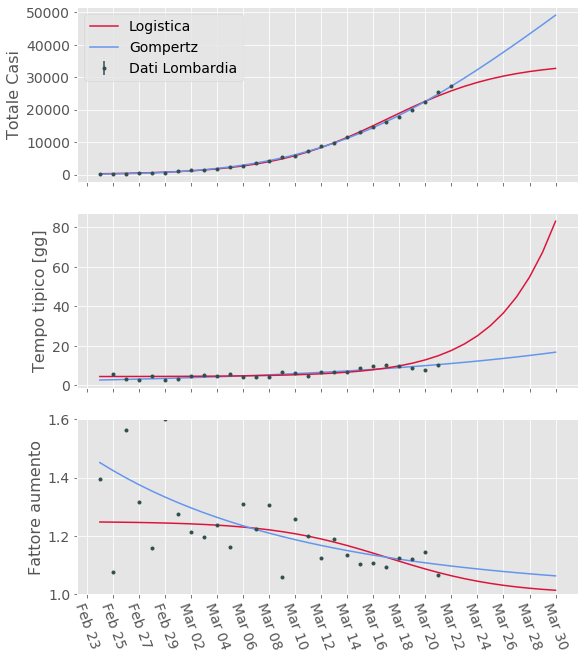

In [88]:
date_proiezione = pd.date_range(dati.index[0],'2020-03-30')


fig,ax = plt.subplots(3,1,sharex=True, gridspec_kw={'height_ratios': [1,1,1]},figsize=(8,9))
# fig,ax = plt.subplots(2,2,sharex=True,figsize=(16,8))

ax = ax.flatten()

fig.tight_layout()

ax[0].errorbar(dati.index,dati,
            yerr=np.sqrt(dati), 
            fmt=".", 
            color="darkslategray", 
            label="Dati Lombardia")

ax[0].plot(date_proiezione,logistica((date_proiezione-dati.index[0]).days, *lopt),label="Logistica",color='crimson')
ax[0].plot(date_proiezione,gompertz((date_proiezione-dati.index[0]).days, *gopt),label="Gompertz",color="cornflowerblue")
# # ax[0].plot(date_proiezione,esponenziale((date_proiezione-dati.index[0]).days, *eopt),label="Esponenziale",color='seagreen')
# ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('')
ax[0].set_ylabel('Decessi')
ax[0].set_ylabel('Totale Casi')

ax[1].plot(date_proiezione,1/rate_gompertz((date_proiezione-dati.index[0]).days, *gopt),label="Gompertz",color='cornflowerblue')
ax[1].plot(date_proiezione,1/rate_logistica((date_proiezione-dati.index[0]).days, *lopt),label="Logistica",color='crimson')
ax[1].errorbar(x=dati.index,y=1/logder(dati),yerr=errprop(dati),fmt='.',color='darkslategray')
# ax[1].set_yscale('log')
# ax[1].plot(date_proiezione,rate_esponenziale((date_proiezione-dati.index[0]).days, *eopt),label="Esponenziale",color='seagreen')
# ax[1].legend()

ax[1].set_xlabel('')
# ax[1].set_ylim(bottom=0,top=0.5)
ax[1].set_ylabel('Tempo tipico [gg]')

ax[2].plot(date_proiezione,logistica((date_proiezione-dati.index[0]).days, *lopt)/logistica((date_proiezione.shift(-1)-dati.index[0]).days, *lopt),label="Logistica",color='crimson')
ax[2].plot(date_proiezione,gompertz((date_proiezione-dati.index[0]).days, *gopt)/gompertz((date_proiezione.shift(-1)-dati.index[0]).days, *gopt),label="Gompertz",color='cornflowerblue')
ax[2].plot(dati.index,dati.shift(-1)/dati,'.',color='darkslategray')
ax[2].set_ylim(bottom=1,top=1.6)
ax[2].set_ylabel("Fattore aumento")
ax[2].tick_params(axis='x', rotation=-70)
ax[2].xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# ax[2].plot(dati.index,np.abs(logistica((dati.index-dati.index[0]).days, *lopt) - dati)/np.sqrt(dati),label="Logistica",color='crimson')
# ax[2].plot(dati.index,np.abs(gompertz((dati.index-dati.index[0]).days, *gopt) - dati)/np.sqrt(dati),label="Gompertz",color="cornflowerblue")
# ax[2].set_ylabel("Residui")
# ax[2].set_ylim(bottom=0)
# ax[2].tick_params(axis='x', rotation=-70)

In [89]:
pro = pd.DataFrame(index=date_proiezione)
    
pro["meno peggio"] = logistica((date_proiezione-dati.index[0]).days, *lopt).astype(int)
pro["male"] = gompertz((date_proiezione-dati.index[0]).days, *gopt).astype(int)
pro["dati"] = dati.astype("Int64")

pro

,meno peggio,male,dati
2020-02-24,246,138,172
2020-02-25,307,196,240
2020-02-26,383,275,258
2020-02-27,477,379,403
2020-02-28,594,513,531
2020-02-29,740,684,615
2020-03-01,920,899,984
2020-03-02,1142,1166,1254
2020-03-03,1415,1492,1520
2020-03-04,1751,1886,1820
